In [1]:
#https://medium.com/data-driven-investment/%E8%B3%87%E7%94%A2%E9%85%8D%E7%BD%AE-%E7%AC%AC%E4%B8%89%E4%BB%A3%E8%B3%87%E7%94%A2%E9%85%8D%E7%BD%AE%E7%90%86%E8%AB%96-black-litterman-b4d2fd855dad
#http://thefjg.blogspot.com/2017/12/black-litterman-portfolio-optimization.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import math
import yfinance as yf

plt.style.use('fivethirtyeight')

In [2]:
portfolio = yf.download(tickers = 'EWA EWZ EWC FXI EWQ EWG EWH EWI EWJ EWY EWN EWS EZA EWP EWD EWL EWT EWU IVV',
                        start="2004-12-01", end="2012-12-31") #Split to two phase 20050101~20121231, 20130101~20191231
table = portfolio['Adj Close']
table.head()

[*********************100%***********************]  19 of 19 completed


,EWA,EWC,EWD,EWG,EWH,EWI,EWJ,EWL,EWN,EWP,EWQ,EWS,EWT,EWU,EWY,EWZ,EZA,FXI,IVV
Date,,,,,,,,,,,,,,,,,,,
2004-11-30,7.896676,12.762678,12.637380,12.478574,7.431767,29.409536,33.034912,12.215910,12.011512,17.818510,15.468410,7.672673,14.795859,19.303463,23.083195,13.156436,21.870142,13.283204,85.755997
2004-12-01,7.910921,12.799629,12.655308,12.780537,7.567339,29.926540,33.483498,12.245328,12.192994,17.929216,15.686834,7.898654,14.874701,19.749098,23.442589,13.314190,21.997082,13.440318,86.771523
2004-12-02,7.953657,12.600097,12.715057,12.773512,7.573501,29.577856,33.611656,12.215910,12.179554,17.955580,15.660362,7.909417,15.058667,19.727358,23.442589,13.169057,21.774239,13.449836,86.851349
2004-12-03,8.015384,12.614877,12.691159,12.899912,7.555014,30.118917,33.707779,12.355647,12.253488,18.134813,15.739788,7.801806,14.992960,19.825182,23.320066,13.415152,21.926559,13.426033,86.757042
2004-12-06,7.929916,12.577924,12.643357,12.899912,7.530367,30.251177,33.355328,12.179136,12.266933,18.176987,15.693452,7.801806,15.242628,19.803440,23.197542,13.440387,21.593704,13.423653,86.807800


In [3]:
returns = table.pct_change()
#sigma = returns.cov()
#implied_excess_return = risk_aversion*np.dot(sigma, weights) #*np.sqrt(252)
#implied_excess_return

In [4]:
#train long short portfolio
i = 23 #2004/12/31
ticker = ['EWA','EWZ','EWC','FXI','EWQ','EWG','EWH','EWI','EWJ','EWY','EWN','EWS','EZA','EWP','EWD','EWL','EWT','EWU','IVV']
nextMonth = 1
#long short portfolio attributes
Q1 = []
Q2 = []
while(i<len(table)-20): #-20 to make sure we can see Q's answer
    #Calculate view'Q in every month's first trading day
    if table.index.month[i]==nextMonth:
        if nextMonth==12:
            nextMonth = 1
        else:
            nextMonth += 1
        #bband (%B) and Bias
        pb = [] #%B
        bias = []
        for t in ticker:
            price = table[t][i-20:i].copy().values.tolist()
            twentyMA = statistics.mean(price)
            bandwidth = statistics.stdev(price)*2
            pb.append((table[t][i]-(twentyMA-bandwidth))/(bandwidth*2))
            bias.append((table[t][i]-twentyMA)/twentyMA)
        pb = np.array(pb)
        bias = np.array(bias)
        #produce view
        future_price = np.array(table[i+1:i+21].copy()) #future 20 day's price as answer
        #view 1's Q
        temp1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        temp2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in np.argsort(pb)[-4:]: #Max 4, relative near upperband
            temp1[j] = 0.25
        for j in np.argsort(pb)[:4]: #min 4, relative near lowerband
            temp2[j] = 0.25
        temp1 = np.array(temp1)
        temp2 = np.array(temp2)
        Q1.append(np.dot(temp1.T,future_price[19])/np.dot(temp1.T,future_price[0]) - np.dot(temp2.T,future_price[19])/np.dot(temp2.T,future_price[0]))
        #view 2's Q
        temp1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        temp2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in np.argsort(bias)[-2:]: #Max 2, big chance to drop
            temp1[j] = 0.5
        for j in np.argsort(bias)[:2]: #min 2, big chance to rise
            temp2[j] = 0.5
        temp1 = np.array(temp1)
        temp2 = np.array(temp2)
        Q2.append(np.dot(temp1.T,future_price[19])/np.dot(temp1.T,future_price[0]) - np.dot(temp2.T,future_price[19])/np.dot(temp2.T,future_price[0]))
    i += 1
#mean return
Q = np.array([statistics.mean(Q1),statistics.mean(Q2)])
#variance covariance
all_record = []
all_record.append(pd.DataFrame(Q1))
all_record.append(pd.DataFrame(Q2))
all_record = pd.concat(all_record,axis=1)
omega = all_record.cov() #use as inverse matirx of omega later
print(Q)
print(omega)

[0.00601852 0.00228543]
          0         0
0  0.000998  0.000673
0  0.000673  0.001278


In [5]:
portfolio = yf.download(tickers = 'EWA EWZ EWC FXI EWQ EWG EWH EWI EWJ EWY EWN EWS EZA EWP EWD EWL EWT EWU IVV',
                        start="2013-01-01", end="2019-12-31") #Split to two phase 20050101~20121231, 20130101~20191231
test = portfolio['Adj Close']
test.head()

[*********************100%***********************]  19 of 19 completed


,EWA,EWC,EWD,EWG,EWH,EWI,EWJ,EWL,EWN,EWP,EWQ,EWS,EWT,EWU,EWY,EWZ,EZA,FXI,IVV
Date,,,,,,,,,,,,,,,,,,,
2012-12-31,17.781155,24.114855,22.925751,21.009813,15.277401,21.560236,34.808922,22.469030,17.516190,23.212053,19.582447,20.644457,22.824318,26.204119,55.820137,45.631187,52.477509,33.196686,122.803612
2013-01-02,18.028702,24.522429,23.214220,21.256491,15.631412,21.896868,35.665752,22.829542,17.661377,23.380812,19.690363,20.946056,23.159479,26.598490,57.247585,46.463226,52.572815,34.345646,125.797768
2013-01-03,17.943827,24.301661,23.016848,20.924753,15.411140,21.624359,35.344444,22.569637,17.447868,23.135344,19.391523,20.765097,22.924866,26.364792,56.269524,46.756882,51.847027,34.132263,125.634781
2013-01-04,18.021629,24.437517,23.206627,21.043839,15.513405,21.912897,35.201641,22.821161,17.584517,23.457518,19.516039,20.750017,22.841076,26.554678,56.040417,46.642681,52.184254,34.156887,126.252464
2013-01-07,17.965052,24.386570,23.130714,20.984293,15.544877,21.720537,34.880325,22.821161,17.618677,23.419168,19.466228,20.553980,22.589705,26.496250,55.573421,46.381660,52.000973,33.886059,125.857834


In [6]:
returns = test.pct_change()

In [7]:
weights = np.array([0.01797,0.00554,0.02888,0.04935,0.02994,0.0239,0.01081,0.00598,0.0751,0.01466,0.01201,0.00316,0.00454,0.00672,0.00773,0.03099,0.0154,0.04248,0.61484])
tau = 0.05
risk_aversion = 3.37

In [8]:
i = 0 #2012/12/31
date = []
AWCI_return = []
all_AWCI_return = []
while(i<len(test)):
    #Calculate return everyday
    date.append(test.index[i])
    if i==0:
        AWCI_return.append(100)
    else:
        daily_return = returns['EWA'][i]*weights[0]+returns['EWZ'][i]*weights[1]+returns['EWC'][i]*weights[2]+returns['FXI'][i]*weights[3]+returns['EWQ'][i]*weights[4]+returns['EWG'][i]*weights[5]+returns['EWH'][i]*weights[6]+returns['EWI'][i]*weights[7]+returns['EWJ'][i]*weights[8]+returns['EWY'][i]*weights[9]+returns['EWN'][i]*weights[10]+returns['EWS'][i]*weights[11]+returns['EZA'][i]*weights[12]+returns['EWP'][i]*weights[13]+returns['EWD'][i]*weights[14]+returns['EWL'][i]*weights[15]+returns['EWT'][i]*weights[16]+returns['EWU'][i]*weights[17]+returns['IVV'][i]*weights[18]
        all_AWCI_return.append(daily_return)
        temp = AWCI_return[i-1]*(1+daily_return)
        AWCI_return.append(temp)
    i += 1

In [9]:
i = 0 #2012/12/31
ticker = ['EWA','EWZ','EWC','FXI','EWQ','EWG','EWH','EWI','EWJ','EWY','EWN','EWS','EZA','EWP','EWD','EWL','EWT','EWU','IVV']
nextRebalanceMonth = 2
date = []
portfolio_return = []
all_portfolio_return = []
while(i<len(test)):
    #balance with view every month
    if test.index.month[i]==nextRebalanceMonth:
        if nextRebalanceMonth==12:
            nextRebalanceMonth = 1
        else:
            nextRebalanceMonth += 1
        #Reset weights to origin one
        weights = np.array([0.01797,0.00554,0.02888,0.04935,0.02994,0.0239,0.01081,0.00598,0.0751,0.01466,0.01201,0.00316,0.00454,0.00672,0.00773,0.03099,0.0154,0.04248,0.61484])
        #bband (%B) and Bias
        pb = [] #%B
        bias = []
        for t in ticker:
            price = test[t][i-20:i].copy().values.tolist()
            twentyMA = statistics.mean(price)
            bandwidth = statistics.stdev(price)*2
            pb.append((test[t][i]-(twentyMA-bandwidth))/(bandwidth*2))
            bias.append((test[t][i]-twentyMA)/twentyMA)
        pb = np.array(pb)
        bias = np.array(bias)
        #produce view
        sigma = returns[i-20:i].copy().cov()
        implied_excess_return = risk_aversion*np.dot(sigma, weights)
        #view 1
        P1 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in np.argsort(pb)[-4:]: #Max 4, relative near upperband
            P1[j] = 0.25
        for j in np.argsort(pb)[:4]: #min 4, relative near lowerband
            P1[j] = -0.25
        #view 2
        P2 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        for j in np.argsort(bias)[-2:]: #Max 2, big chance to drop
            P2[j] = 0.5
        for j in np.argsort(bias)[:2]: #min 2, big chance to rise
            P2[j] = -0.5
        P = np.array([P1,P2])
        #new return, sigma and weights
        #r1 = np.linalg.inv(np.linalg.inv(tau*sigma)+np.dot(np.dot(P.T,omega),P))
        #r2 = np.dot(np.linalg.inv(tau*sigma),implied_excess_return)+np.dot(np.dot(P.T,omega),Q)
        #r_posterior = np.dot(r1,r2)
        r_posterior = implied_excess_return + np.dot( np.dot( tau*np.dot(sigma,P.T), np.linalg.inv(tau*np.dot(np.dot(P,sigma),P.T)+omega)), (Q-np.dot(P,implied_excess_return)))
        #sigma_posterior = r1
        #sigma += sigma_posterior
        sigma_posterior = sigma + tau*sigma - tau*np.dot( np.dot( np.dot(sigma,P.T), np.linalg.inv(tau*np.dot(np.dot(P,sigma),P.T)+omega)), tau*np.dot(P,sigma))
        weights = np.dot(np.linalg.inv(risk_aversion*sigma_posterior),r_posterior)
    #Calculate return everyday
    date.append(test.index[i])
    if i==0:
        portfolio_return.append(100)
    else:
        daily_return = returns['EWA'][i]*weights[0]+returns['EWZ'][i]*weights[1]+returns['EWC'][i]*weights[2]+returns['FXI'][i]*weights[3]+returns['EWQ'][i]*weights[4]+returns['EWG'][i]*weights[5]+returns['EWH'][i]*weights[6]+returns['EWI'][i]*weights[7]+returns['EWJ'][i]*weights[8]+returns['EWY'][i]*weights[9]+returns['EWN'][i]*weights[10]+returns['EWS'][i]*weights[11]+returns['EZA'][i]*weights[12]+returns['EWP'][i]*weights[13]+returns['EWD'][i]*weights[14]+returns['EWL'][i]*weights[15]+returns['EWT'][i]*weights[16]+returns['EWU'][i]*weights[17]+returns['IVV'][i]*weights[18]
        all_portfolio_return.append(daily_return)
        temp = portfolio_return[i-1]*(1+daily_return)
        portfolio_return.append(temp)
    i += 1

Text(0, 0.5, 'Accumulate return')

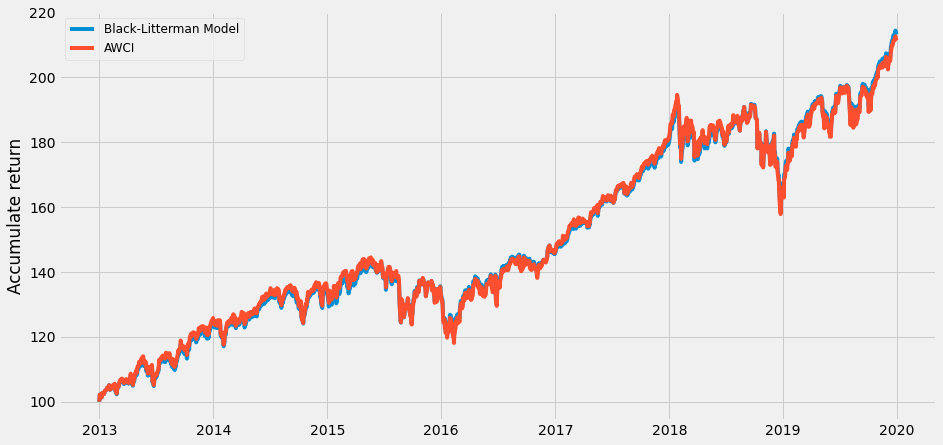

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(date,portfolio_return,label='Black-Litterman Model')
plt.plot(date,AWCI_return,label='AWCI')
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Accumulate return')

In [11]:
#Annual Return
print(math.pow(portfolio_return[len(portfolio_return)-1]/100,1/7))
print(math.pow(AWCI_return[len(AWCI_return)-1]/100,1/7))

1.1143108535448876
1.1128983649514506


In [12]:
#Annual Volatility
print(statistics.stdev(all_portfolio_return)*np.sqrt(252))
print(statistics.stdev(all_AWCI_return)*np.sqrt(252))

0.12209919542232538
0.12826468749124795


In [13]:
#Return/ Risk
print((math.pow(portfolio_return[len(portfolio_return)-1]/100,1/7)-1)/(statistics.stdev(all_portfolio_return)*np.sqrt(252)))
print((math.pow(AWCI_return[len(AWCI_return)-1]/100,1/7)-1)/(statistics.stdev(all_AWCI_return)*np.sqrt(252)))

0.936212995912881
0.8801983395402893
